# Imports

## Import models

### Common imports

In [ ]:
from PIL import Image
import requests
import torch

### CLIP

In [ ]:
from transformers import CLIPProcessor, CLIPModel

### EasyOCR

In [6]:
%pip install git+https://github.com/JaidedAI/EasyOCR

  Cloning https://github.com/JaidedAI/EasyOCR to /tmp/pip-req-build-j22ub8b7
  Running command git clone --filter=blob:none --quiet https://github.com/JaidedAI/EasyOCR /tmp/pip-req-build-j22ub8b7
  Resolved https://github.com/JaidedAI/EasyOCR to commit c999505ef6b43be1c4ee36aa04ad979175178352
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 26.5 MB/s eta 0:00:00
  Created wheel for easyocr: filename=easyocr-1.7.1-py3-none-any.whl size=77013662 sha256=94dfeaccf8bc45bacdb6f05c129fd2c5dbd2be24962fd40c89291cb78a256113
  Stored in directory: /tmp/pip-ephem-wheel-cache-gz2utbql/wheels/ce/93/79/7e20b0429516a0ed6ef2bf37973602a3f0186f16ce184717a6
Successfully built easyocr


In [7]:
import easyocr
from PIL import ImageDraw

## General imports

In [27]:
import numpy as np
import statistics
from sklearn.metrics import confusion_matrix

# Global declarations

In [9]:
allergens = {
    "gluten": 0,
    "eggs": 1,
    "milk": 2,
    "nuts": 3,
    "peanuts": 4,
    "soja": 5,
    "molluscs": 6,
    "fish": 7,
    "lupin": 8,
    "crustaceans": 9,
    "sesame": 10,
    "mustard": 11,
    "celery": 12,
    "sulphites": 13
}

nb_allergens = len(allergens)

# Body

## CLIP prediction

In [10]:
model_CLIP = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor_CLIP = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [11]:
def predict_CLIP(image, allergen):
    image = Image.open(image)
    match allergen:
        case 0:
            inputs = processor_CLIP(text=["ingredient list of a product containing wheat or gluten", "ingredient list of a product without wheat nor gluten"], images=image, return_tensors="pt", padding=True)
        case 1:
            inputs = processor_CLIP(text=["ingredient list of a product containing eggs", "ingredient list of a product without eggs"], images=image, return_tensors="pt", padding=True)
        case 2:
            inputs = processor_CLIP(text=["ingredient list of a product containing milk", "ingredient list of a product without milk"], images=image, return_tensors="pt", padding=True)
        case 3:
            inputs = processor_CLIP(text=["ingredient list of a product containing nuts", "ingredient list of a product without nuts"], images=image, return_tensors="pt", padding=True)
        case 4:
            inputs = processor_CLIP(text=["ingredient list of a product containing peanuts", "ingredient list of a product without peanuts"], images=image, return_tensors="pt", padding=True)
        case 5:
            inputs = processor_CLIP(text=["ingredient list of a product containing soya", "ingredient list of a product without soya"], images=image, return_tensors="pt", padding=True)
        case 6:
            inputs = processor_CLIP(text=["ingredient list of a product containing molluscs", "ingredient list of a product without molluscs"], images=image, return_tensors="pt", padding=True)
        case 7:
            inputs = processor_CLIP(text=["ingredient list of a product containing fish", "ingredient list of a product without fish"], images=image, return_tensors="pt", padding=True)
        case 8:
            inputs = processor_CLIP(text=["ingredient list of a product containing lupin", "ingredient list of a product without lupin"], images=image, return_tensors="pt", padding=True)
        case 9:
            inputs = processor_CLIP(text=["ingredient list of a product containing crustaceans", "ingredient list of a product without crustaceans"], images=image, return_tensors="pt", padding=True)
        case 10:
            inputs = processor_CLIP(text=["ingredient list of a product containing sesame", "ingredient list of a product without sesame"], images=image, return_tensors="pt", padding=True)
        case 11:
            inputs = processor_CLIP(text=["ingredient list of a product containing mustard", "ingredient list of a product without mustard"], images=image, return_tensors="pt", padding=True)
        case 12:
            inputs = processor_CLIP(text=["ingredient list of a product containing celery", "ingredient list of a product without celery"], images=image, return_tensors="pt", padding=True)
        case 13:
            inputs = processor_CLIP(text=["ingredient list of a product containing sulphites", "ingredient list of a product without sulphites"], images=image, return_tensors="pt", padding=True)

    outputs = model_CLIP(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

    return round(probs[0][0].item())

In [22]:
def predict_allergens_CLIP(image):
    prediction = []
    for allergen in range(0, 14):
        prediction.append(predict_CLIP(image, allergen))
    return prediction

## EasyOCR Prediction

In [13]:
reader = easyocr.Reader(['en'], gpu=False)  # English

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [34]:
def predict_allergens_EasyOCR(image):
    # ------------ Extract text ---------------------
    #image_path = 'CLIP/feature_engineering_dataset/enhanced_data/002.jpg'
    result = reader.readtext(image)
    text = ' '.join(item[1] for item in result)
    text = text.lower()
    # -----------------------------------------------

    prediction = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    print(text)

    if "gluten" in text or "wheat" in text:
        prediction[allergens['gluten']] = 1
    if "egg" in text:
        prediction[allergens['eggs']] = 1
    if "milk" in text or "whey" in text:
        prediction[allergens['milk']] = 1
    if "nut" in text:
        prediction[allergens['nuts']] = 1
    if "peanut" in text:
        prediction[allergens['peanuts']] = 1
    if "soja" in text or "soy" in text:
        prediction[allergens['soja']] = 1
    if "mollusc" in text:
        prediction[allergens['molluscs']] = 1
    if "fish" in text or "tuna" in text or "salmon" in text or "cod" in text or "tilapia" in text or "sardine" in text:
        prediction[allergens['fish']] = 1
    if "lupin" in text:
        prediction[allergens['lupin']] = 1
    if "crustacean" in text:
        prediction[allergens['crustaceans']] = 1
    if "sesame" in text:
        prediction[allergens['sesame']] = 1
    if "mustard" in text:
        prediction[allergens['mustard']] = 1
    if "celery" in text:
        prediction[allergens['celery']] = 1
    if "sulphite" in text:
        prediction[allergens['sulphites']] = 1
        print("hey")

    return prediction

## Read Excel File

In [15]:
import pandas as pd

In [17]:
excel_file = pd.read_excel('labellisation.xlsx')
excel_file = excel_file.iloc[0:219, 1:15]

excel_file

,gluten,egg,milk,nuts,peanuts,soya,molluscs,fish,lupin,crustaceans,sesame,mustard,celery,sulphites
0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Enhanced Data Performance Comparison

In [24]:
results_CLIP = pd.DataFrame()

for image in range(1, 51):
    prediction_CLIP = predict_allergens_CLIP(f"{datasets/enhanced_dataset/image:03d}.jpg")
    results_CLIP = results_CLIP.append(pd.Series(prediction_CLIP, name=f"{image}"))

results_CLIP

<ipython-input-24-9b11c24cfa1a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_CLIP = results_CLIP.append(pd.Series(prediction_CLIP, name=f"{image}"))
<ipython-input-24-9b11c24cfa1a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_CLIP = results_CLIP.append(pd.Series(prediction_CLIP, name=f"{image}"))
<ipython-input-24-9b11c24cfa1a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_CLIP = results_CLIP.append(pd.Series(prediction_CLIP, name=f"{image}"))
<ipython-input-24-9b11c24cfa1a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_CLIP = results_CLIP.append(pd.Series(prediction_CLIP, name=f"{image}"))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,1,1,1,1,0
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,0,1,1,1,1,1,1,1,1,0
10,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [26]:
test_CLIP = excel_file.iloc[:50,:]
test_CLIP

,gluten,egg,milk,nuts,peanuts,soya,molluscs,fish,lupin,crustaceans,sesame,mustard,celery,sulphites
0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
print("gluten")
print(confusion_matrix(results_CLIP.iloc[:, 0].round(),test_CLIP['gluten'],labels=[1,0]))
print("egg")
print(confusion_matrix(results_CLIP.iloc[:, 1].round(),test_CLIP['egg'],labels=[1,0]))
print("milk")
print(confusion_matrix(results_CLIP.iloc[:, 2].round(),test_CLIP['milk'],labels=[1,0]))
print("nuts")
print(confusion_matrix(results_CLIP.iloc[:, 3].round(),test_CLIP['nuts'],labels=[1,0]))
print("peanuts")
print(confusion_matrix(results_CLIP.iloc[:, 4].round(),test_CLIP['peanuts'],labels=[1,0]))
print("soya")
print(confusion_matrix(results_CLIP.iloc[:, 5].round(),test_CLIP['soya'],labels=[1,0]))
print("molluscs")
print(confusion_matrix(results_CLIP.iloc[:, 6].round(),test_CLIP['molluscs'],labels=[1,0]))
print("fish")
print(confusion_matrix(results_CLIP.iloc[:, 7].round(),test_CLIP['fish'],labels=[1,0]))
print("lupin")
print(confusion_matrix(results_CLIP.iloc[:, 8].round(),test_CLIP['lupin'],labels=[1,0]))
print("crustaceans")
print(confusion_matrix(results_CLIP.iloc[:, 9].round(),test_CLIP['crustaceans'],labels=[1,0]))
print("sesame")
print(confusion_matrix(results_CLIP.iloc[:, 10].round(),test_CLIP['sesame'],labels=[1,0]))
print("mustard")
print(confusion_matrix(results_CLIP.iloc[:, 11].round(),test_CLIP['mustard'],labels=[1,0]))
print("celery")
print(confusion_matrix(results_CLIP.iloc[:, 12].round(),test_CLIP['celery'],labels=[1,0]))
print("sulphites")
print(confusion_matrix(results_CLIP.iloc[:, 13].round(),test_CLIP['sulphites'],labels=[1,0]))

gluten
[[26  1]
 [15  8]]
egg
[[ 6  2]
 [ 6 36]]
milk
[[12  0]
 [25 13]]
nuts
[[ 6  3]
 [13 28]]
peanuts
[[ 1  4]
 [ 2 43]]
soya
[[ 8  2]
 [31  9]]
molluscs
[[ 0  4]
 [ 0 46]]
fish
[[ 1  3]
 [ 1 45]]
lupin
[[ 0  7]
 [ 0 43]]
crustaceans
[[ 2  6]
 [ 3 39]]
sesame
[[ 3 12]
 [ 2 33]]
mustard
[[ 0 22]
 [ 8 20]]
celery
[[ 4  9]
 [ 1 36]]
sulphites
[[ 0  5]
 [ 3 42]]


In [155]:
results_EasyOCR = pd.DataFrame()

for image in range(1, 51):
    prediction_EasyOCR = predict_allergens_EasyOCR(f"{datasets/enhanced_dataset/image:03d}.jpg")
    results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))

results_EasyOCR

irl gb cake rollwith vanilla flavour filling (18%) and strawbente spread (18) ingredients: sugar wheat riour (ezole bad ( {e99oe water, margarine ipalm at colzar?is ategremutsererstarch; piat stabilizers (e422, e420), wheat starch;_ starch, whey godee syiu;, strdwberty puree concentrate (187, rasing agents (e450, esooepalmkernedfat acid (e30},salt geling agents e440 e40rec emulsifters [e471, e492 and e322 (soyll thickener (e4152,acidity (e331, e341j, elderberry_juice fat reduced cocoa natural flavouring; preservative e2o29ealergyadvice; forallergens see ingredieio5 a? balde may also contain traces ofnuts and sulphites average nutritional value: akick fturatac vegetable potato powder regulators powder;
hey


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


rl gb cake with vanilla flavoured filling and raspberry spre  , covered with imitation marzipan and chocolate ilavoured coating: ingredients: sugar; vegetable fats (palm; palm kernel coconut? barn eggs, raspberry puree (4.5%), wheat flour soya beans rapeseed oil; glucose syrup, wheat starch apricot kernels (1.8%) , stabilizers (e420 e422, e1103)  glucose fructose syrup, soya flour; fat reduced cocoa powder (0.8%). skimmed milk powder; water, emulsifiers (mono- and diglycerides of fatty acids, sorbitan tristearate; soya lecithin), thickener (xanthan gum) , salt; gelling agents (pectin, sodium alginate) , acidity regulators (citric acid,sodium citrate) natural flavouring, raising agents (disodium diphosphate; sodium hydrogen carbenate}, fruit and plant concentrates (carrot; blackcurrant), flavouring; preservative (potassium sorbate). 'advice: for allergens see ingredients in bold: also contain nuts allergy may


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


gb) lemon flavoured cake with 10 % chocolate flzvoured wouting ingredients: sugar, eggs, wheat flour; palm fai w heat starch humectants: sorbitols, glycerol; fully ldcrolemoedoiain fat glucose-fructose-syrup, low cocoa powder, oil, 'lime oil, salt; raising scs sodium carbonates; emulsifiers: mono- diglycerides of fatty acids, sorbitan tristearate, lecithins (sov); acidity sodium acetates; colour: carotenes certified sustainable oil) . this product may contain traces 0f nuts and milk products packaged in a protective atmosphere. store in a cool, place best before: see side of pack regulator: palm dry


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


gb marble cake with 1 % low-fat cocoa powder and 10 chocolate flavoured coating ingredients: sugar; eggs, wheat flour palm fat wheat scarcki humectants: sorbitols glycerol; fully hydrogenated palm fat glucose-fructose-syrup , fat cocoa powder salt; raising agents  diphosphates sodium carbonates; natural flavouring emulsifiers: mono-and diglycerides of fatty acids sorbitan tristearate, lecithins (sop  acidity regulator; sodium acetates; colour: carotenes: certified sustainable palm oil)_ this product may contain traces %f nuts and milk products packaged in & protective atmosphere. store in a cool; de best before: see side of pack. co % low dry place:


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


gb cake with 3 % marzipan and 10 % chocolate flavoured coating: ingredients: sugar, wheat floun eg88 fat wheat starch, humectants: sorbitols glycerol; fully hydrogenated palm fat giucose-fructose-syrup,louifat cocoa powder ialmonds rice' flour, salt, raising agents: diphosphates, sodium carbonates; emulsifiers: mono- and diglycerides of fatty acids,sorbitan tristearate, lecithins (soy); natural flavouring ecidin saulato; acidity sodium acetates; colour: carotenes certified le oil)_ this may contain traces of other nuts de miik products: packaged in @ protective atmosphere store in du 0 cool; best before: see side of pack: fru palm palm and product place. dry


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


en chocolate with sweeteners. sugars free; emulsifier: lecithin (soy2) sweetener ingredients: sweetener; maltitol cocoa mass, cocoa butter; hazelnut and mii cocoa solids: 52k steviol glycosides from stevia, 3 flavouring: may be present: almond, seiiogncexcessive consumption may produce laxative effects


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


en aued (52) milk (hocolate with sweeteners with no added sugars ingredients: sweetener: maltitol  cocoa mass, cocoa butter, milk powder, skimmed milk powder, vegetable fat (palm, kernel), hazelnuts (5%) , whey powder (milk), fat-reduced cocoa powder; emulsifier: lecithin (sopa): sweetener;: steviol glycosides from stevia,flavourings be present: almond. cocoa solids: 36% minimum in milk chocolate milk solids: 20% minimum in milk chocolate excessive consumption may produce laxative effects. contains naturally occurring sugars palm may


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


en chocolate with sweeteners . sugars free ingredients; cocoa mass; cocoa butter, fat-reduced cocoa powder, sweetener: maltitol emulsifier: lecithin (soya) sweetener: steviol glycosides from stevia: be present: almond, hazelnut and milk cocoa solids: 85% minimum; excessive consumption may produce laxative effects mav


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


44 ob syrup, emulsiiier ing redients: with mass, cocoa raising agent (sodium (lecithins (soy))], syrup, carbonates, oil (25%) and egg_ (palm, sunflower) contain traces of box allergy advice: flavour; may keep in a storage see ingredients in opening cookies glucose butter; plain chocolate (25%). wheat cocoa salt, flour, pieces glucose-fructose dark [sugar chocolate vegetable sugar caramel). milk diphosphates) , nuts, (plain natural closed colour for bold. allergens, instructions: after ce:


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


irl | gb butter biscuits with milk chocolate (63%). sugar; wheat flour; cocoabutter cocoa mass, skimedeenilk pgaderheatteotniocog > whey ponider emuksif dotec emilk) , glucose syrup; lactose (milk) ertelsifier concentrated (sodium carbonates and diphosphates), (lecithins) , raising agents acid (citric acid). salt; milk powder; flavourings, dried egg advice: for allergens, see ingredients iroboloc hazelnuts. allergy produced in a facility that also processes this product is   snol from heat. yolk


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


irl gb sponge cake with dark chocolate (17%) and raspberry flavour (55%). irredients: sugar; glucose fructose syrup, (heat flour, cocoa mass liquid whole egg (6,0 %) , palm oil, cocoa butter; concentrated raspberry juice (1,2 %), stabilisier (sorbitoo, gelling agent (pectins), acid (citric acid), agents (sodium carbonates and diphosphates) powder (milk) , emulsifiers (lecithins and mono- and diglycerides of acids) , flavourings, salt, starch (wheat) advice: for allergens see ingredients in bold ` this product is produced in a facilityethat sa also processes hazelnuts and almonds th filling raising whey fatty allergy


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


wheatmeal biscuits covered in dark chocolate ingredients: flour (39%) (wheat flour, calcium; niacin, thiamin), dark chocolate (30%) [sugar, cocoa mass, vegetable fats (palm, shea), butter oil (milk} cocoa butter, emulsifiers (soya lecithin; e476) natural flavouring] vegetable oil (palm) wholemeal wheat flour (9%6). sugar; glucose-fructose syrup, raising agents (sodium bicarbonate, malic acid; ammonium bicarbonate), salt: hmwaing cereals containing gluten aowmmmamaens- eceiuedient in 6e4e iron;


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


wheatmeal biscuits covered in milk chocolate ingredients: flour (39%) (wheat flour, calcium; iron; niacin; thiamin}; milk chocolate (30%) [sugar, cocoa butter, cocoa mass, dried skimmed milk, dried (milk), butter oil (milkk) vegetable fats (palm, shea) emulsifiers (soya lecithin; e476)4 natural flavouring]; vegetable oil (palm) wholemeal wheat flour (9%), sugar; glucose-fructose syrup, raising agents (sodium bicarbonate, malic acid, ammonium bicarbonate) salt kmn viuanurumanueetaneeetele51e cortetrirotuten, 202 hrae i_khosieeekdenioeanln whey


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


uk sandwichbiscuits with cocoaflavouredfilling wheat) sugar; fat fatreduced cocoa* 3,5%,5 salt; skimmed millzpowder; pea sodiumstearoyl-2-lactylate; agent ammonium carbonates madein stora - barley; 270,  irgredients:" vegetablet flour; : (palm);, { glucose powder= syrup;  protein, emulsifiers: | lecithins; raisiiiy factoryalsoe nutsandoats: using;rye


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


poeuer: los and dotju/0 tistens in ae volle melkcnocolade: kan sporen van schaalvruchten en pindas bevatten; geproduceerd in duitsland. rijst eu. cacao niet-eu: (gb) whole milk chocolate 'pefied (wheat-rice-extrudate) ingredients; whole milk chocolate 83% (sugar whole milkpowder; cocoa butter cocoa mass sweet whey powder emulsifiers: e22 (soya), "tatuiah miiouonauffeghic 15%,wheat-rice-extrudate 2% (rice flour; whole wheat_ wheat flour rye flour sugar skimmedmilkpowder food grade salt) cocoa solids: 30% minimum in the whole milk chocolate; milk contain traces of nuts and peanuts product of germany: rice from eu: cocoa non-eu: (cz) cokoladova ryze 5 mlecnou cokoladou, burizony & psenicno-ryzovym extrudatem  slozeni: mlecne cokolady 83% (cukr, susene plnotucne' kakaove maslo, kakaova hmota,susena sladka syrovatka, emulgator: e322 (soja) e476, prirodni aroma) 15%6, _ mouka, celozrnna nsenitnamouka nsenitno mouka titno moukatrukiceko, kakaove masio, sdadiedla sil) cobsab kakaauv slsine min

<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


en: cocoa biscuit with filling coated win milk chocolaue ingredents: milk chocolate 479 (sugas cocoa butter cocoa mass milk (powder; powder; emulsier (soya lecithin) flavours) wheat flous 1696 [sugar jat (palm oil and ] kernetoil wheat starch; milk proteins skimmed mik powder emulsitier (sova iecitrin) sugar,vegetable iat (palm) tat-reduced cocoa powder 3%6 wth acidityregulators potassum carbonateand sodium carbonate) raisingagents (sodumhydrogen carbonate, ammonium hydrogen carbonate) salt emuisifter (soya lecithin} flavour: es. galleta decacao rellena de crema recubierta de chocolate con leche ingredientes: chocolate palm vegetable kiing whey]


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


en cocoa biscvit wih filling coated with white chocdlate ingredients: white chocolate 47% [sugar; cocoa butter milk powder = 'powder emulsifer (soya lecithin) favours} wheat flling 1696 [sugar vegetable fat (palm; palm kemel; wheatstarch milk proteins; skimmed mik powder emulsifer (soya lecithin]l, sugar vegetable tat (patmj tat-reduced cocoa powder 39  acidity regulators: potassium carbonate and sodium carbonate} raising agents (sodium bydrogen carbonate, ammonium hydrogen carbonate} sal; emulsifer (soya lecinink navoue; whey houg; t (wiu


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


en; cocoa biscuit with filling: ingredients: wheat ilour; { 299 [sugar wheat starch; vegetable fat (palm and palm kernel); favour; emulsifier (soya lecithin} natural favour], sugar vegetable oil (high oleic sunilower oi} fat-reduced cocoa powder 5% (wth acidity regulators: potassium carbonate and sodium carbonate}, agents (sodium hydrogen carbonate, ammonium hydrogen carbonate), satt emulsifier (soya lecitinj; favour: 'contain baces of milk and mustard / es galleta de cacao rellena de crema ingredientes: harina de trigo; crema 29v [azucaralmidon de brigo; grasa (palma y palmiste}; aroma;, emulgente (lecitina de soja} aroma natural; azicar; aceite vegeial (giasol alo oleico) cacao desgrasado en polvo 5% con correctores de acidez: carbonato potasico y carbonato sodico), gasiticantes (carbonato acido de sodio; carbonato acido de amonio} sal, emulgente (ecitna filling ' may xraising vegetal 


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


en; cocoa biscjit wix alling; ingredients: wheat fiour; 299k  wheat starch; vegetable fat (palm and palm kerel; iavour; emulsifier (soya lecithin) natural iavoud sug35 vegetable gi (igh eleic suniower %11faf-reduced cocoa rannad 57 (wiu "tera2989 regulaol poessur carponate and sodum carbonate} aising agenis (sodium  encanenae; ammonunhyarogen carbonate] sal emuster(soyalecining havour may conlainiacesdimik e5 @ oeadecacaortoecret ingredientes: detrigo crema azica almidon det gusauegea gamaypamister aromas emuigente ecinade sojin roma namal e7canocenevegeraikeuesdraigdeco cacao desgrasado enpovo 57con corteci9ues deacidez caronaigpoasico y caroonaio sodico) gesticantes carponang3nnogersogio caroonan acido de  denu0 ear emugenie ecina desojaysaroma puede contener vazns deieche fu,bolachs decachdrechzdacomcrene ingredlentes: farinha detrgg creme 298 jacicar; rricodetzgoonoode amido de " ivegetal (palma e palmiste) aroma,emulsionante (eciina de soizh aroma natural acucar, ded vecebal garoe

<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


ingredients: dlepper andlomal (lavoured wholegrain rye rye flour seasoning mix [maltodextrin; cheese powder;onion; paprka; tomato; veast extract; garlic, spice, regulator (lactic acid) , flavouringl sunflower oil, water; yeast may contain traces of sesame seeds sloreina dry cheese, onion, > snacks wholegrain sugar; 75%,5 salt, dextrose , milk) , (from (paprika); whey  powder extract acidity ' spice place dark and


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


and onion flavoured wholegrain rye snacks sour wholegrain rye flour 79%, suntlower oil,seasoning mix ingredients: = salt; dextrose; dried onion natural flavour; powder; dried baatfodexeaist ealt zersou cream powder (milk) acidity (lactic acid, parsley, antioxidant (rosemary extract)]; water; calcium lactate); contain traces of seeds. store in a and dark place. cream gb yeast regulators yeast yeast  garlic, dried sesame dry may


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


is mt paprika gadkers; ingredients: wheat flour; l oil, glucosesyrp raisingagents (ammonium @rbonates qdum arponates  aaltespicegregeita 03 % pexper) davoui enhaecer geonosodium 9hu2n6150) snionroeder hydrolysed vegetable protein; powder; dlavouringflour treatment (sodium extrac, smoke flavouring may zarlic ov egg,soya, mik l8 aenannnincaco naudres $ lever (carbonates palm yeast agent


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


ingredients: wheat flour, oil, glucose syrup, barley malt extract, raising agents carbonates, sodium carbonates),   salt, eggs,  flavouring; flour   treatment agent(sodium e) . may contain soya, milk: d0 (rackers- palm @mmonium meiibisulfit = er


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


salted peanuts_ [rl | gb roasted and salted peanuts: peanuts sunflower oil ingredients: salt: for allergens see nllergy may contain "neredients in of other ctore in a (95%), advice: also bold. beces nuts: cool ct


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


ih yegelbl pils savoury snack. ingredients: dehydraled @ice palm; corn) in varying proportions; wheat |oug com paprika (sugar; paprika powder (avour enhances disodium guanyiate , disodium inosinatek dextnose sall; granulated broth (salt; hydrolysed  acid} oil}; garlic powdes; colour (papria erbaeh o sall; powder {milk}l maltodextrin; emulsifier = ina contain soy. best before; botiom (@94 av gons" aimacnl a  jepi svack  paphia flavour !polaloes (sunilower; uou; $  hour; " seasoning [monosodium glutamate; heasl powder; ' onion 'vegelable powder; proleln; = sunilower iciric ilavourings; sweel whey (e471} colour ! (annatlo packagedi norbixin): may see 'sale proteciive =


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


mango-perzik , mango-melocoton , mango-pesca _ manga-pessego fermented sovayghurtaltenative withmango andpeach ingredients soyajice* 789wates soyabeans* 1084} (mango* 72%, 28%} rawaanesugar"?,natunl ipeach flavouring , naturalmango favouring';, tapoaasard; fruits* 9% ilemonjuice", thickener: iocustbeangum: selectedlivecultures of which bifdusand lactobadius sfairtrade) highprotein naturallygluten free gmofree addophilus "organi erentierte bio alternativezu joghurtaus sojamit mangound ptirsich zutaten: sojazubereituna* 78% (wasser organic / peach* concentrated ingredients ingredients "


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


(e153) , sulungsmittel (acesulfam-k, sucralose). ila" gb: gummy candy with no added sugars with sweeteners. ingredients: deo sdearossalaxeiauor isomalto-oligosaccharides water, sweetener (bovine), ammonium chloride,liquorice flavouring, sweetener (acesulfame-k, sucralose). a source 0f c7 ce honhonv hez nridaneho cukru s niichut liquorice  ' fibre} (erythritoll cotours (glucose "solmj


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


iev cheese and onon flavour savoury snack. ingredehts: delyuaklyhiz vegebableois (sunlbwer palm; com)in varying proporions; wheatt com lbutlu 'cheese & onion  (onion powder; dextrose; maltodextrin; gtucose sjp; iaw enhancers (monosodium glutamate; disodium guanyiale; disodiumn noshae} c mabe starch;, sal; yeast extract; lactose (milk} ibxohh (al; ivegetable protein; sunllower oil} cheese {milki} acids |acicai emulsifier (e471}, salt; colour (annatto norbni iay contain soy: before: see bottom (bb}  packaged in a dwesphere siore in a cool dry place; (de1 knabbergeback ht kase wd zwifrei cron haealiahe dle iloug; c seasoning modd granulaled [ flavourings; hydrolysed powder  cilric acid]); maltodextrin, prolective best


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


irl |gb" dipping sauce with jalapeno pepper edammer cheese (milk) oil, modified starch (tapioca, maize) _ red pepper; onion, milk protein, green chili peppers, salt; sugar (milk) , coconut oil stabilizers extract, colour: e16oc allergens see inaredients in cheese ingredients: ` water, (10%) , rapeseed tomato paste , sweet jalapero peppers (1,7%) , emulsifier (e452) , flavourings (e415, e412]), spices, herb allergy - advice: bold: averade for


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


gb sauce made with avocado. green avocado (15%), onions; sweet pepper; rapeseed oil_cheese_ emulsifying salts (e331, maize starch, sugar; oil red sweet pepper; milk antioxidant (e3oo) acid (e330), stabilizers flavourings. in allergens see t7e irl |' dip ingredients: tomatoes; water, preparation e451 icheese e450, (milk) , e339, e4521], pepper chili modified green coconut salt; proteins; jalapeno concentrated peppers; spices lemon e412), juice , (e415, colours (e16oa, bold allergy - e141) , ingredients advice: average for energy


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


gb tomato based sauce with sweet peppers medium; ingredients: water, tomatoes (18%), tomato red sweet pepper (7,2%) , onions; green sugar; spirit vinegar, modified maize pepper (0,9%), spices (incl garlic extracts of paprika: in for alleraens sze irl (11%), paste pepper sweet salt; (4,8%) , starch; natural jalapeno mustard) , flavouring; bold: allergy ~ ingredients advice:


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


irl | gb wheat flour tortillas: wheat flour (66%), water, oil, itoiedeents4z7he466,08412 raising agents: es00, {ablizeal; eciz? e2966 emuisifier: e471; dextrose: e450; salt, e202, flour treatment agent: e920. preservatives: e282, dvice: for allergens see ingredients in bold: palm


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


redients: noodles: wheaz flour; palm oil (palm oil, aniioxidant: tap starch, modified starch: e1442, soup (flavouring; ` extzct, ilavhancer: e635) , salt; thickener: e466. oras; palm oil (paim oi, antioxidane6e3062 satt (crilatpbboesorier 0.890), fiavour enhancers: e621, e635, spices 0 0.2%, cinnamon 0.1% , ginger 0.1%) i sugar; ~csoybean; glucose syrup, trin, acid: 9 beef flavouringof crustaceans; fish milk celery de contain carine de ble huile de 'huli4z, soupe e3o6), yeast (chili; powder sauce soy e296, acid: e330) , maltodex seeds: sesame _ c1 and_ 50c _ palme; (huile #ivuct traces palme may


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


'iavoa = e306) , c1_ oil (palm oin , extract, (flavouring, yeast leaf 1 oil (palm e466_ 7% _ oil, antioxidant:; e3o6) , vegetables (garlic) sesaoduct tavouring; flavour ennarcei5; e621 , e635. ja 0.1%) , corn starch, acid: e296, color: e15oc of crustaceans, fish, soy, milk celery and ingredienis. ioodles: whfai  starch, flour ; modified paliil = antioxidant: gondimbancerirc starch: 442 , e635) , soup salt inkw palm thickener: (sge' (%1) , spices satt tls (chili chicken 0.5%, = may pepper contain seeds. traces diente


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


ingredients ingredients- zl,xh ingredtients ingredienten (8 noodles soltweatfburlglutenl vegetablecllsmesscapl (antainsantixidant (eobll walersalt scaoning: wheat  maltodextrin sugar favourenhancers (e621, e6322627 onioni vegetabl dheflasocalooraniisakng (e551)acditye (b330) olllpalm mesocarp} dredchives crustaceans milk maycontaintracesofcelery;' nolsuc = fannedebletendre(gluten} huilewgetale (palmemener lcol soit tout att powder; yeastextact; soya)_ regulator agent farne 


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


ingredients ingredients-zl; f-ingredients ingredienten g8 noodles softwheat flour (gluten}  oil mesgarp) ((containgartixoant(eobllwater salt seasnng-sat softineeo27 andktodextrin sugacflavourenhancess e6zacebegetabl (gluten) soya crustaceans) eastextrarg shrimpflavour (contairssovasrustaceansde-cst-caking oil (palmg36,242r2884ir 3i2eiertilk- huile vegetale (alme agent 3 un sagrine debietendre (c (gluten) hueeassaisonnemer (palm vegetable vegetable (e551) ble contain


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


ingrfdients ingredients-<l;aaj yredients-ingredienten gb noodles soltwheat flour(gluten) vegetableollpalmmesoc (containsantixidant (e0b1,water; salt seasoning: salt soltwheat (gluten} maltodextrin, sugar; exkancers (e621 e62x, 16z7) beefflavour(contains soyal yeastextract colour (€1 50anegetable oil (palm mesocarp); agent (e551) driedchive maycontain tracesof crustaceans milk f noille flavour anti-caking celery;


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


2 p wheat semolina irl | durum wheat semolira allergens see allergy in contain traces ingredients soy: 4 0 pasta: durum gb ingredients: for advice: bold:. may 8f


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


pasta durum durum and for bold. may rrlncb semolina ingtedtents: wheat semolina. allergy wheat . ingredients see allergens soy advice: ~ustard_ contain in


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


irl | gb durum wheat semolina pasta. ingredients: durum wheat semolina. advice: for allergens ingredients in bold. soy and mustard allergy see contain may


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


wheat semolina pasta | gb durum ingredients: durum wheat advice: for allergens soy ingredients in bold: may irl semolina: see and allergy contain mustard:


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


lo ulclle wheat semolina durum wheat allergens of in may contain and irl | gb durum pasta ingredients: semolina: allergy advice: for see ingtedients traces bold. soy egg:


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


0nannd adnnn gb durum wheat semolina pasta. ingredients: durum wheat semolina, water. contain traces of soy and mustard. store in a cool and cooking instructions: 100g 0 1 litre water 7g salt. bring water to a fast boil and add salt add pasta and cook for p4 minutes, stirring occasionally drain and serve gb: imported by euro food brands , kimbell mews, boughton, nnz 8xb,uk for uk & ireland: to contact barilla: www barillacouk 49 duado dry place may pasta


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


gb durum wheat semolina pasta. ingredients: durum wheat semolina, water: contain traces of soy and mustard. store in a cool and cooking id  {aea ~ndaddalt dry place. may


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


gb ie mt durum wheat semolina egg pasta. ingredients: durum wheat semolina, e995 (19.369) 'contain traces ofs0yand mustard store in a cool and dry place cooking instructionstinang (19.369) may contain tratesorsoyated toa fastboil and add salt add pasta and cookfor 8 minutes stirring may


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


irl gb cornflakes. ingredients: maize (93%) , sugar, salt, barley malt extract. allergy advice: for allergens see ingredients in bold.


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


maitseaine. kakaosisaldus vahemalt 33%. voib sisaldada muid pahkleid ja nisu: gb is mt alpine milk chocolate: ingredients: sugar; cocoa butter, cocoa mass, skimmed milk powder; powder (from milk) , milk fat; emulsifier (soya lecithins) hazelnut paste,flavouring: cocoa solids 33 % minimum. milk solids 18 % minimum: may contain other nuts and wheat: whey


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


 gb is m alpine milk chocolate with vanilla flavour filling (42 %) and cocoa biscuit pieces (12 %) ingredients: sugar; fats (palm; kernel), skimmed milkpowder; cocoa butter; wheat flourcocoa mass wheypowder (from milk), milkfat fat-reduced cocoa powder (0,7 emulsifier (soyalecithins) , glucose-fructose syrup; wheat starch; hazelnutpaste raisingagents (e503,e501,e5o0), salt; flavourings, acidity regulator (e524). milk solids: 18 % minimum in the alpine milk chocolate. may contain other nuts. vegetable _ palm %),


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


gb is mdalpine milk chocolate with crunchyalmond caramelpieces (20%) ingredients: sugar, cocoa butter; cocoa mass; skimmed milk powder; powder (from milk) , palm oil, milk fat, almonds (1 %), sweetened condensed skimmed milk; emulsifier (soya lecithins) , hazelnut paste, salt; permeate (from milk), flavourings cocoa solids: 33 % minimum in the alpine milk chocolate. milk solids: 18 % minimum in the alpine milk chocolate. may contain wheai; whey" whey =


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


is md alpine milk cocolate flled with cramel flavour filling (35 %) and cramel filling (15 %) ingredients: = oil, cocoa butterskimmed milk powder glucose syrup; cocoa mass; 'powder (from milk), milk fat glucose-fructose _ emulsifers sovilegthins e47llhazelnutpaste flavourings salt miksolas: 18% minimumin the aapinerk choolatesh4y; contain other nuts and wheat: sugar;  palm , whey e


<ipython-input-155-37cd9a0aaf45>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_EasyOCR = results_EasyOCR.append(pd.Series(prediction_EasyOCR, name=f"{image}"))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1,1,0,1,1,0,1,0,0,0,0,0,0,0,1
2,1,1,1,1,0,1,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0,0,0,0,0
5,1,0,0,1,0,1,0,0,0,0,0,0,0,0
6,0,0,0,1,0,1,0,0,0,0,0,0,0,0
7,0,0,1,1,0,0,0,0,0,0,0,0,0,0
8,0,0,1,1,0,1,0,0,0,0,0,0,0,0
9,1,1,1,1,0,1,0,0,0,0,0,0,0,0
10,1,1,1,1,0,0,0,0,0,0,0,0,0,0


In [156]:
print("gluten")
print(confusion_matrix(results_EasyOCR.iloc[:, 0],test_CLIP['gluten'],labels=[1,0]))
print("egg")
print(confusion_matrix(results_EasyOCR.iloc[:, 1],test_CLIP['egg'],labels=[1,0]))
print("milk")
print(confusion_matrix(results_EasyOCR.iloc[:, 2],test_CLIP['milk'],labels=[1,0]))
print("nuts")
print(confusion_matrix(results_EasyOCR.iloc[:, 3],test_CLIP['nuts'],labels=[1,0]))
print("peanuts")
print(confusion_matrix(results_EasyOCR.iloc[:, 4],test_CLIP['peanuts'],labels=[1,0]))
print("soya")
print(confusion_matrix(results_EasyOCR.iloc[:, 5],test_CLIP['soya'],labels=[1,0]))
print("molluscs")
print(confusion_matrix(results_EasyOCR.iloc[:, 6],test_CLIP['molluscs'],labels=[1,0]))
print("fish")
print(confusion_matrix(results_EasyOCR.iloc[:, 7],test_CLIP['fish'],labels=[1,0]))
print("lupin")
print(confusion_matrix(results_EasyOCR.iloc[:, 8],test_CLIP['lupin'],labels=[1,0]))
print("crustaceans")
print(confusion_matrix(results_EasyOCR.iloc[:, 9],test_CLIP['crustaceans'],labels=[1,0]))
print("sesame")
print(confusion_matrix(results_EasyOCR.iloc[:, 10],test_CLIP['sesame'],labels=[1,0]))
print("mustard")
print(confusion_matrix(results_EasyOCR.iloc[:, 11],test_CLIP['mustard'],labels=[1,0]))
print("celery")
print(confusion_matrix(results_EasyOCR.iloc[:, 12],test_CLIP['celery'],labels=[1,0]))
print("sulphites")
print(confusion_matrix(results_EasyOCR.iloc[:, 13],test_CLIP['sulphites'],labels=[1,0]))

gluten
[[35  1]
 [ 6  8]]
egg
[[10  0]
 [ 2 38]]
milk
[[30  0]
 [ 7 13]]
nuts
[[18  4]
 [ 1 27]]
peanuts
[[ 2  0]
 [ 1 47]]
soya
[[34  0]
 [ 5 11]]
molluscs
[[ 0  0]
 [ 0 50]]
fish
[[ 2  2]
 [ 0 46]]
lupin
[[ 0  0]
 [ 0 50]]
crustaceans
[[ 5  0]
 [ 0 45]]
sesame
[[ 3  0]
 [ 2 45]]
mustard
[[ 7  0]
 [ 1 42]]
celery
[[ 4  0]
 [ 1 45]]
sulphites
[[ 1  0]
 [ 2 47]]


# CLIP and Logistic Regression

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [75]:
import matplotlib.pyplot as plt

In [142]:
def evaluateLR_gluten():
  X = results_CLIP.iloc[:, 0]
  X = np.array(X).reshape(-1, 1)
  y = test_CLIP['gluten'] == 1
  accuracy = []
  test_sizes = [0.1,0.2,0.3,0.4,0.5]
  for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=0)
    # Initialize the logistic regression model
    logistic_model = LogisticRegression()
    # Fit the model on the training data
    logistic_model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = logistic_model.predict(X_test)
    # Evaluate the model
    accuracy.append(accuracy_score(y_test, y_pred))
  plt.plot(test_sizes, accuracy, marker='o', linestyle='-')
  plt.title('Accuracy Scores vs Test Sizes')
  plt.xlabel('Test Size (%)')
  plt.ylabel('Accuracy Score')
  plt.grid(True)
  plt.show()

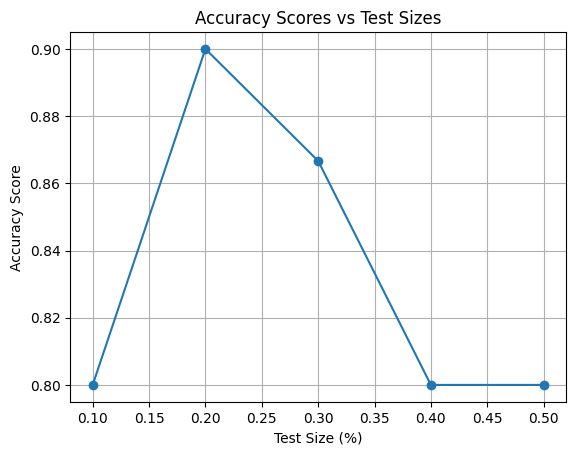

In [143]:
evaluateLR_gluten()

In [144]:
def evaluateLR_egg():
  X = results_CLIP.iloc[:, 1]
  X = np.array(X).reshape(-1, 1)
  y = test_CLIP['egg'] == 1
  accuracy = []
  test_sizes = [0.1,0.2,0.3,0.4,0.5]
  for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=0)
    # Initialize the logistic regression model
    logistic_model = LogisticRegression()
    # Fit the model on the training data
    logistic_model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = logistic_model.predict(X_test)
    # Evaluate the model
    accuracy.append(accuracy_score(y_test, y_pred))
  plt.plot(test_sizes, accuracy, marker='o', linestyle='-')
  plt.title('Accuracy Scores vs Test Sizes')
  plt.xlabel('Test Size (%)')
  plt.ylabel('Accuracy Score')
  plt.grid(True)
  plt.show()

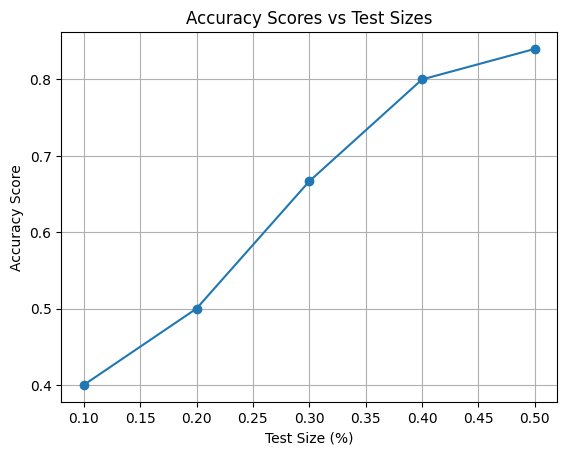

In [145]:
evaluateLR_egg()

In [146]:
def evaluateLR_milk():
  X = results_CLIP.iloc[:, 2]
  X = np.array(X).reshape(-1, 1)
  y = test_CLIP['milk'] == 1
  accuracy = []
  test_sizes = [0.1,0.2,0.3,0.4,0.5]
  for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=0)
    # Initialize the logistic regression model
    logistic_model = LogisticRegression()
    # Fit the model on the training data
    logistic_model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = logistic_model.predict(X_test)
    # Evaluate the model
    accuracy.append(accuracy_score(y_test, y_pred))
  plt.plot(test_sizes, accuracy, marker='o', linestyle='-')
  plt.title('Accuracy Scores vs Test Sizes')
  plt.xlabel('Test Size (%)')
  plt.ylabel('Accuracy Score')
  plt.grid(True)
  plt.show()

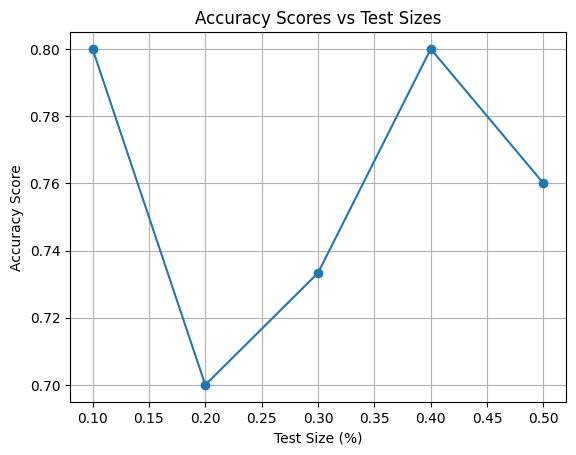

In [147]:
evaluateLR_milk()

In [148]:
def evaluateLR_nuts():
  X = results_CLIP.iloc[:, 3]
  X = np.array(X).reshape(-1, 1)
  y = test_CLIP['nuts'] == 1
  accuracy = []
  test_sizes = [0.1,0.2,0.3,0.4,0.5]
  for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=0)
    # Initialize the logistic regression model
    logistic_model = LogisticRegression()
    # Fit the model on the training data
    logistic_model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = logistic_model.predict(X_test)
    # Evaluate the model
    accuracy.append(accuracy_score(y_test, y_pred))
  plt.plot(test_sizes, accuracy, marker='o', linestyle='-')
  plt.title('Accuracy Scores vs Test Sizes')
  plt.xlabel('Test Size (%)')
  plt.ylabel('Accuracy Score')
  plt.grid(True)
  plt.show()

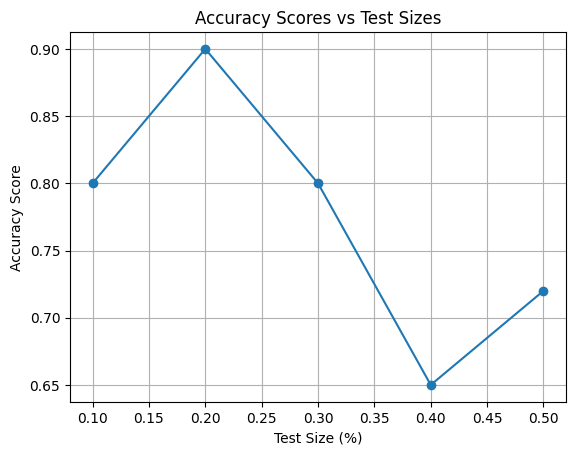

In [149]:
evaluateLR_nuts()